# Programming Quantum Bits with Qiskit


Last updated on June 16, 2022

A notebook accompanying the presentation at [a tutorial of the 36th JSAI](https://www.ai-gakkai.or.jp/jsai2022/tutorial) on June 17, 2022 in Kyoto.

https://www.ai-gakkai.or.jp/jsai2022/tutorial


Rudy Raymond
rudyhar@jp.ibm.com

# Outline of this notebook

* Installation and Getting Started
  * What is Qiskit?
  * Quantum Superposition
  * Quantum Entanglement
* Checking equivalence of circuits

But first, install qiskit:

In [1]:
!pip install qiskit

We can check the version of qiskit installed by:

In [2]:
import qiskit
from pprint import pprint
pprint(qiskit.__qiskit_version__)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


{'qiskit-terra': '0.20.0', 'qiskit-aer': '0.10.3', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.18.3', 'qiskit-aqua': None, 'qiskit': '0.35.0', 'qiskit-nature': '0.3.2', 'qiskit-finance': '0.3.1', 'qiskit-optimization': '0.3.2', 'qiskit-machine-learning': '0.3.1'}


# Installation Steps

  * Please follow the official steps here: https://qiskit.org/documentation/install.html
  * Otherwise, follow the un-official steps here: https://github.com/t-imamichi/qiskit-utility/wiki/Unofficial-installation-guide-of-qiskit

Keep in mind:
  * **Qiskit is very much a work in progress**. It is changing rapidly to converge toward the needs of its users.

# Quantum Superposition

Let's start programing with the simplest case using one qubit.

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np
%matplotlib inline

In [4]:
# Create a Quantum Register with 1 qubit
qr = QuantumRegister(1)

# Create a Classical Register with 1 bit
# Necessary to measure/know the value of the quantum bit with measurement
cr = ClassicalRegister(1)

# Create a Quantum Circuit acting on the qr and cr register
circuit = QuantumCircuit(qr, cr)

# QuantumCircuits are the primitives for Quantum Computing
* QuantumCircuits in Qiskit are backend agnostic: runnable with simulators or real devices
* They contain a list of gates in the circuit and initialized with:
  * name - for referencing the circuit later (e.g. in the results object)
  * regs - the QuantumRegisters and ClassicalRegisters in the gates of the circuit


# Quantum Gates

There are many gates defined in Qiskit. The basis gateset of the IBM Q devices is {CX, u3}: all other single- and mult-qubit gates are defined from the combination of those gatesets. 

The list of available gates is [here](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/fundamentals/7_summary_of_quantum_operations.ipynb).

After we add some gates, we can print our circuit's Qasm (a kind of assembler code with basis gates)

In [5]:
# flip gate on qubit 0
#circuit.x(qr[0])
# Hadamard gate on qubit 0
circuit.h(qr[0])

print(circuit.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q0[1];
creg c0[1];
h q0[0];



We can also use the `draw()` function to visualize the circuit:

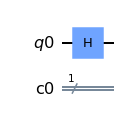

In [9]:
#circuit.draw()
circuit.draw(output="mpl")
#circuit.draw(output="latex")

Let us run the circuit with a simulator backend that we can use for debugging and learning quantum gates. 

In [10]:
from qiskit import BasicAer as Aer
from qiskit import execute

stv_backend = Aer.get_backend('statevector_simulator')

job = execute(circuit, stv_backend)

result = job.result()

output_state = result.get_statevector(circuit, decimals=4)
print(output_state)

[0.7071+0.j 0.7071+0.j]


We can also plot the state vector on the bloch sphere.

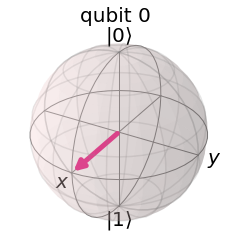

In [11]:
from qiskit.visualization import plot_bloch_multivector

plot_bloch_multivector(output_state)

We can find out the unitary matrix corresponding to the sequence of gates in the circuit with the unitary simulator backend: 

In [12]:
uni_backend = Aer.get_backend("unitary_simulator")

job = execute(circuit, uni_backend)
result = job.result()
pprint(result.get_unitary(circuit, decimals=4))

array([[ 0.7071+0.j,  0.7071-0.j],
       [ 0.7071+0.j, -0.7071+0.j]])


# Tips
Showing the equivalence of gates/circuits becomes easy:

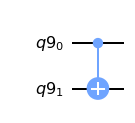

In [13]:
_q1 = QuantumRegister(2)

_qc1 = QuantumCircuit(_q1)
_qc1.cx(_q1[0], _q1[1])

_qc1.draw(output="mpl")

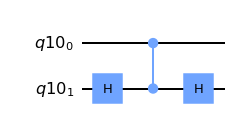

In [14]:
_q2 = QuantumRegister(2)

_qc2 = QuantumCircuit(_q2)
_qc2.h(_q2[1])
_qc2.cz(_q2[0], _q2[1])
_qc2.h(_q2[1])

_qc2.draw(output="mpl")

In [15]:
_job1 = execute(_qc1, uni_backend)
_result1 = _job1.result()

_job2 = execute(_qc2, uni_backend)
_result2 = _job2.result()

pprint("CX")
pprint(_result1.get_unitary(_qc1, decimals=4))

pprint("I-H CZ I-H")
pprint(_result2.get_unitary(_qc2, decimals=4))

'CX'
array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]])
'I-H CZ I-H'
array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]])


Notice that the matrix of Controlled-NOT ("CX") in qiskit looks different from that in the textbook:

**Textbook (left-to-right bit ordering)**
$$
\left|0\right>\left<0\right| \otimes \mathbf{I} + \left|0\right>\left<0\right| \otimes \mathbf{X}
$$

**Qiskit (right-to-left bit ordering)**
$$
\mathbf{I} \otimes \left|0\right>\left<0\right| + \mathbf{X} \otimes \left|1\right>\left<1\right|
$$

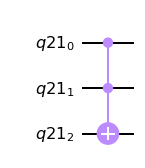

In [16]:
# The first circuit consists of a Toffoli gate
q1 = QuantumRegister(3)
qc1 = QuantumCircuit(q1)

qc1.ccx(q1[0], q1[1], q1[2])

qc1.draw(output="mpl")

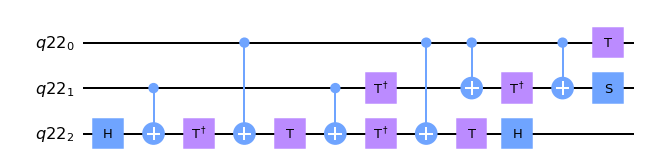

In [17]:
# Decomposition of Toffoli gate
q = QuantumRegister(3)
qc = QuantumCircuit(q)

qc.h(q[2])
qc.cx(q[1], q[2])
qc.tdg(q[2])
qc.cx(q[0], q[2])
qc.t(q[2])
qc.cx(q[1], q[2])
qc.tdg(q[2])
qc.cx(q[0], q[2])
qc.tdg(q[1])
qc.t(q[2])
qc.h(q[2])
qc.cx(q[0], q[1])
qc.tdg(q[1])
qc.cx(q[0], q[1])
qc.t(q[0])
qc.s(q[1])
qc.draw(output="mpl")

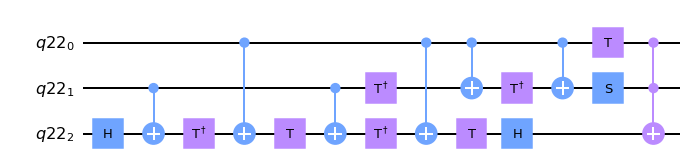

In [18]:
from qiskit import BasicAer as Aer
from qiskit import execute
uni_backend = Aer.get_backend("unitary_simulator")

#append to qc the toffoli gate
qc.ccx(q[0], q[1], q[2])

#confirm that the Toffoli gate is appended
qc.draw(output="mpl")

In [19]:
#run the unitary simulator
job = execute(qc, uni_backend)
result = job.result()
from pprint import pprint
pprint(result.get_unitary(qc, decimals=4))

array([[1.-0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.-0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.-0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.-0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.-0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.-0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.-0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.-0.j]])


In [20]:
#to be sure we can compare with identity
import numpy as np

toffoli_plus_toffoli = result.get_unitary(qc)

#check if all elements of the two arrays are close within a tolerance
np.allclose(toffoli_plus_toffoli, np.eye(8))

True

Let us get back to the 1-qubit circuit we wrote before: 

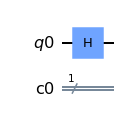

In [21]:
circuit.draw(output="mpl")

Measurement must be made to access the information within the qubit:

/tmp/ipykernel_79/3864611654.py:5: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = circuit + meas


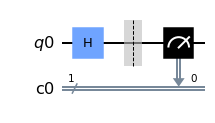

In [22]:
meas = QuantumCircuit(qr, cr)
meas.barrier(qr)
meas.measure(qr, cr)

qc = circuit + meas

qc.draw(output="mpl")

**Deprecated "+" operation of Circuits**


We really should use the compose function as below

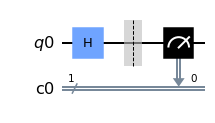

In [53]:
qc = circuit.compose(meas) #use this instead of circuit + meas

qc.draw(output="mpl")

We can simulate the measurement results (as if running the circuit on the real device).

In [23]:
sim_backend = Aer.get_backend("qasm_simulator")

nshots = 1000

job_sim = execute(qc, sim_backend, shots=nshots)

result_sim = job_sim.result()

counts = result_sim.get_counts(qc)
pprint(counts)

{'0': 520, '1': 480}


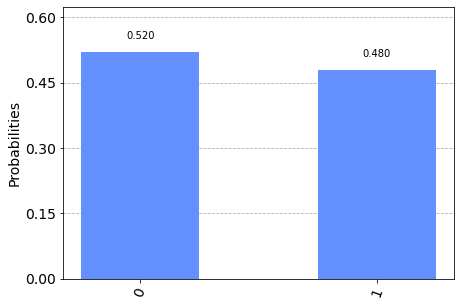

In [24]:
#plotting with histogram
from qiskit.visualization import plot_histogram

plot_histogram(counts)

We can check the probability of measuring "0" and "1" with the previous circuit, that outputs $\left|+\right> = \frac{1}{\sqrt{2}} \left( \left|0\right> + \left|1\right> \right)$, is the same with the following circuit, that outputs $\left|-\right> = \frac{1}{\sqrt{2}} \left( \left|0\right> - \left|1\right> \right)$.

/tmp/ipykernel_79/3524192106.py:4: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = circuit + zg + meas


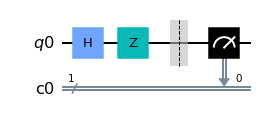

In [25]:
zg = QuantumCircuit(qr, cr)
zg.z(qr[0])

qc = circuit + zg + meas
qc.draw(output="mpl")

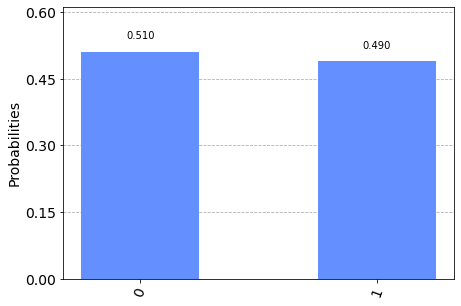

In [26]:
job_sim = execute(qc, sim_backend, shots=nshots)

result_sim = job_sim.result()

counts = result_sim.get_counts(qc)
plot_histogram(counts)

How to differentiate $\left|+\right>$ and $\left|-\right>$ states? In this case, we can rotate the states before measurement in the computational bases. 

/tmp/ipykernel_79/1069670493.py:5: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc1 = circuit + hg + meas
/tmp/ipykernel_79/1069670493.py:6: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc2 = circuit + zg + hg + meas


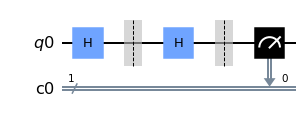

In [27]:
hg = QuantumCircuit(qr, cr)
hg.barrier(qr[0])
hg.h(qr[0])

qc1 = circuit + hg + meas
qc2 = circuit + zg + hg + meas

qc1.draw(output="mpl")

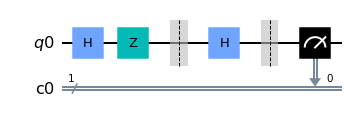

In [28]:
qc2.draw(output="mpl")

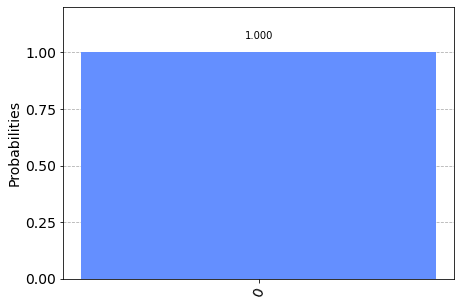

In [29]:
job_sim = execute(qc1, sim_backend, shots=nshots)

result_sim = job_sim.result()

counts = result_sim.get_counts(qc1)
plot_histogram(counts)

# Quantum Entanglement

Quantum entanglement is another powerful feature of quantum bits. Let us see the entangled state of the quantum bits from the following circuit. The qubits are called **entangled** if their state cannot be written as the tensor product of the states of their individual qubits, i.e., $\left|\psi\right>_{12} \neq \left|\phi\right>_1 \otimes \left|\phi\right>_2$.

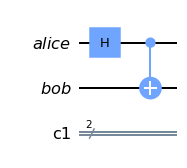

In [30]:
qra = QuantumRegister(1, "alice")
qrb = QuantumRegister(1, "bob")
cr = ClassicalRegister(2)

bell = QuantumCircuit(qra, qrb, cr)

bell.h(qra[0])
bell.cx(qra[0], qrb[0])
bell.draw(output="mpl")

The quantum state is the famous *EPR*-pair (for Einstein-Podolsky-Rosen), that is, 

$$
\frac{1}{\sqrt{2}} \left( \left|00\right> + \left|11\right> \right).
$$

Notice that the above state is equivalent to

$$
\frac{1}{\sqrt{2}} \left( \left|+\right>\left|+\right> + \left|-\right>\left|-\right> \right),
$$
where $\left|+\right> = \frac{1}{\sqrt{2}} \left( \left|0\right> + \left|1\right> \right)$, and $\left|-\right> = \frac{1}{\sqrt{2}} \left( \left|0\right> - \left|1\right> \right)$


Imagine the two qubit state is shared by two distant parties: Alice (the 1st-qubit) and Bob (the 2nd-qubit). They are free to measure their own qubit either:

    1. by measuring in the standard basis
    2. or, by measuring in the "+", "-" basis
    
The EPR-pair implies that the measurement at one party instantenously effect the measurement result at other party. But, information cannot travel faster than light! Something *spooky* happens with the EPR-pair. We see this partially at our last exercise:

1. What is the probability of observing “0” on the first qubit AND “1” on the second qubit? 
2. What is the probability of observing $\left|+\right>$ on the first qubit? What is the state of the qubits after the measurement?
3. What is the state of the qubits after measuring the qubits with measurement operators 
$$
\mathbf{I} \otimes (\frac{1}{\sqrt{3}} \left|0\right> + \frac{\sqrt{2}}{\sqrt{3}} \left|1\right>)(\frac{1}{\sqrt{3}} \left<0\right| + \frac{\sqrt{2}}{\sqrt{3}} \left<1\right|)
$$

Consider the following cases depending on the choices of measurement basis of Alice and Bob:

1. Alice measures in standard basis, Bob in standard basis
2. Alice measures in "+/-" basis. 
3. Bob measures in the basis of 
$$
(\frac{1}{\sqrt{3}} \left|0\right> + \frac{\sqrt{2}}{\sqrt{3}} \left|1\right>), (\frac{\sqrt{2}}{\sqrt{3}} \left|0\right> - \frac{1}{\sqrt{3}} \left|1\right>)
$$




In [31]:
alice_std = QuantumCircuit(qra, qrb, cr)
alice_std.barrier(qra)
alice_std.measure(qra[0], cr[0])

alice_pm = QuantumCircuit(qra, qrb, cr)
alice_pm.barrier(qra)
alice_pm.h(qra[0])
alice_pm.measure(qra[0], cr[0])

bob_std = QuantumCircuit(qra, qrb, cr)
bob_std.barrier(qrb)
bob_std.measure(qrb[0], cr[1])

bob_pm = QuantumCircuit(qra, qrb, cr)
bob_pm.barrier(qrb)
bob_pm.h(qrb[0])
bob_pm.measure(qrb[0], cr[1])

#circuit for case 1
case1 = bell + alice_std + bob_std

#circuit for case 2
#case2 = bell + alice_pm
case2 = bell + alice_pm + bob_pm

/tmp/ipykernel_79/4106532267.py:20: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  case1 = bell + alice_std + bob_std
/tmp/ipykernel_79/4106532267.py:24: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  case2 = bell + alice_pm + bob_pm


Plots of the circuits:

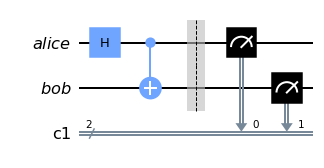

In [32]:
#Alice and Bob in standard basis
case1.draw(output="mpl")

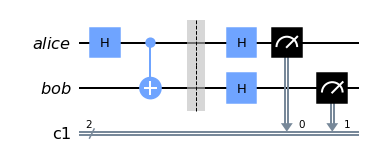

In [33]:
#Alice in pm, Bob does nothing
case2.draw(output="mpl")

# Running experiments with simulators

In [34]:
jobs = execute([case1, case2] , sim_backend, shots=10000)

results = jobs.result()

result_case1 = results.get_counts(case1)
result_case2 = results.get_counts(case2)


pprint("Case1")
pprint(result_case1)
pprint("")

pprint("Case2")
pprint(result_case2)
pprint("")


'Case1'
{'00': 4981, '11': 5019}
''
'Case2'
{'00': 5005, '11': 4995}
''


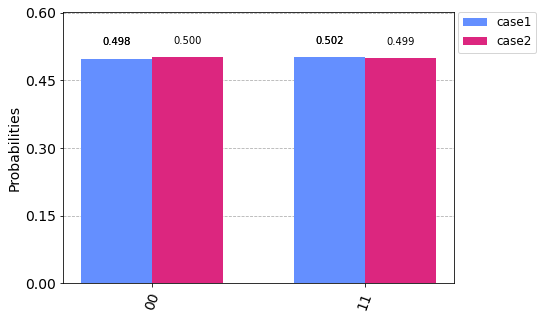

In [35]:
plot_histogram([result_case1, result_case2], legend=["case1", "case2"])

# Preparing working with real-device backends

In [36]:
from qiskit import IBMQ

IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-internal', group='trl', project='qiskit')>,
 <AccountProvider for IBMQ(hub='ibm-q-internal', group='deployed', project='default')>]

# The IBMQ Provider: Executing on Quantum Hardware


To do this, you'll need to get an IBM Quantum Experience API token from the [IBM Quantum Experience accounts page](https://quantum-computing.ibm.com/).

In [37]:
# IBMQ.enable_account('<key>')
# uncomment this ^^^ and put your API key in
provider = IBMQ.get_provider(hub='ibm-q-internal', group="deployed")
#provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-internal', group='deployed', project='

In [39]:
real_backend = provider.get_backend('ibmq_lima')

In [40]:
pprint(real_backend.name())
pprint("--")
pprint(real_backend.status())
pprint("--")
pprint(real_backend.configuration())

'ibmq_lima'
'--'
'--'


## Back again to the Bell experiment circuit:

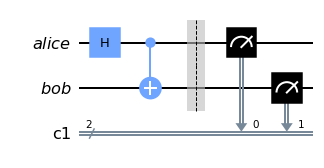

In [41]:
case1.draw(output="mpl")

In [42]:
import qiskit.tools.jupyter  # importing tools for watching job from jupyter

shots = 1000        # Number of shots to run the program (experiment); maximum is 8192 shots.
job_exp = execute(case1, real_backend, shots = shots)

In [46]:
# Check the job status
job_exp.status()

<JobStatus.QUEUED: 'job is queued'>

In [48]:
#%qiskit_job_watcher
%qiskit_disable_job_watcher

FYI, you can also retrieve an old job by its job_id.

In [49]:
jobID = job_exp.job_id()

print('JOB ID: {}'.format(jobID))

job_get=real_backend.retrieve_job(jobID)
job_get.result().get_counts(case1)

JOB ID: 6261055f6354d63becaa4c99


{'00': 453, '01': 19, '10': 20, '11': 508}

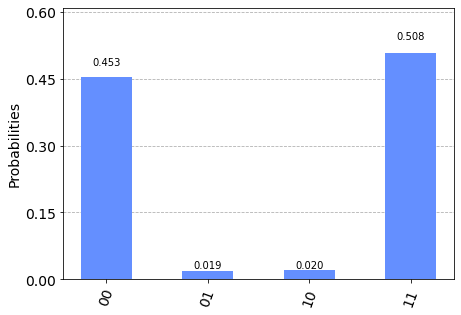

In [50]:
counts = job_get.result().get_counts(case1)
plot_histogram(counts)

# Learning resources

The [qiskit textbook](https://qiskit.org/textbook/preface.html) contains ready-to-run tutorials ranging from basics concepts of quantum computing to basic quantum algorithms.

* For learning functions of Qiskit, see: [qiskit-tutorials/](https://github.com/Qiskit/qiskit-tutorials) directory


In [51]:
import qiskit.tools.jupyter
%qiskit_version_table